# Support Vector Machine with SDAE

## 1. Imports

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import numpy as np
import pandas as pd

# Classifier
from sklearn.svm import SVC

# Character N-gram feature extractor
from sklearn.feature_extraction.text import CountVectorizer

# Util
from data_io import get_book
import torch
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder

# Keras 
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.optimizers import Adam

# Plotting
import matplotlib.pyplot as plt

import tensorflow as tf

2023-04-13 12:33:20.776499: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-13 12:33:20.879505: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-13 12:33:20.902474: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-13 12:33:21.327881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

## 2. Create the training, test and validation sets

In [3]:
train_data = pd.concat(pd.read_csv("train.csv", chunksize = 100))

In [4]:
train_data = pd.concat(pd.read_csv("train.csv", chunksize = 100))
# test_data = pd.concat(pd.read_csv("test.csv", chunksize = 100))
# val_data = pd.concat(pd.read_csv("val.csv", chunksize = 100))

train_data = train_data.iloc[0:3]
test_data = train_data.iloc[0:1]
val_data = train_data.iloc[1:2]

cv = CountVectorizer(analyzer='char', ngram_range=(1, 5), dtype=np.float32, max_features=10000)
X_train, X_test, X_val = cv.fit_transform(train_data.text.tolist()), cv.transform(test_data.text.tolist()), cv.transform(val_data.text.tolist())  
Y_train, Y_test, Y_val = train_data.author.tolist(), test_data.author.tolist(), val_data.author.tolist()

**Convert labelled data into numbers**

In [5]:
Encoder = LabelEncoder()
Y_train = Encoder.fit_transform(Y_train)
Y_test = Encoder.transform(Y_test)
Y_val = Encoder.transform(Y_val)

print(np.array(Y_train))

[0 2 1]


**Distribution of Training Data**

In [6]:
print(X_train.shape)
# print(cv.vocabulary_)
print(len(train_data.text.tolist()[1].split(" ")))

one_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 1]
print("total occurrences of length 1 char n-gram")
print(sum(one_ngram_occurrences))
print("total amount of length 1 char n-gram")
print(len(one_ngram_occurrences))

two_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 2]
print("total occurrences of length 2 char n-gram")
print(sum(two_ngram_occurrences))
print("total amount of length 2 char n-gram")
print(len(two_ngram_occurrences))

three_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 3]
print("total occurrences of length 3 char n-gram")
print(sum(three_ngram_occurrences))
print("total amount of length 3 char n-gram")
print(len(three_ngram_occurrences))

four_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 4]
print("total occurrences of length 4 char n-gram")
print(sum(four_ngram_occurrences))
print("total amount of length 4 char n-gram")
print(len(four_ngram_occurrences))

five_ngram_occurrences = [cv.vocabulary_[ngram] for ngram in cv.vocabulary_ if len(ngram) == 5]
print("total occurrences of length 5 char n-gram")
print(sum(five_ngram_occurrences))
print("total amount of length 5 char n-gram")
print(len(five_ngram_occurrences))

(3, 10000)
22448
total occurrences of length 1 char n-gram
160589
total amount of length 1 char n-gram
27
total occurrences of length 2 char n-gram
2072474
total amount of length 2 char n-gram
365
total occurrences of length 3 char n-gram
10683903
total amount of length 3 char n-gram
1976
total occurrences of length 4 char n-gram
19119360
total amount of length 4 char n-gram
3808
total occurrences of length 5 char n-gram
17958674
total amount of length 5 char n-gram
3824


**Data Normalization using MinMax Scaler**

In [7]:
from sklearn.preprocessing import MinMaxScaler

X_train, X_test, X_val = X_train.toarray(), X_test.toarray(), X_val.toarray()

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

print(X_train_scaled)

[[0.99999994 1.         1.         ... 0.6478873  0.67164177 0.5294118 ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.65674055 0.58286643 0.80767155 ... 0.99999994 1.         1.        ]]


## 3. SVM without SDAE

In [8]:
model_names = ['Raw SVM', '1-layer SDAE SVM', '2-layers SDAE SVM', '3-layers SDAE SVM']
predicted_arr = []

In [9]:
svm = SVC(kernel='linear', C=1)
svm.fit(X_train_scaled, Y_train)
preds = svm.predict(X_test_scaled)

# print(Y_test)
# print("############################################")
# print(preds)
print("SVM Accuracy Score on test -> ", metrics.accuracy_score(preds, Y_test)*100)
print("SVM Accuracy Score on training -> ", metrics.accuracy_score(svm.predict(X_train_scaled), Y_train)*100)
print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(svm.predict(X_val_scaled), Y_val)*100)

predicted_arr.append(preds)

SVM Accuracy Score on test ->  100.0
SVM Accuracy Score on training ->  100.0
SVM Accuracy Score on validation ->  100.0


## 4. SVM with SDAE

### 4.1 Class for tying weights in a denoising auto encoder

In [10]:
# Code referenced from https://medium.com/@lmayrandprovencher/building-an-autoencoder-with-tied-weights-in-keras-c4a559c529a2

class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)

    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
  
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

### 4.2 Class for construction of a denoising autoencoder

In [11]:
np.random.seed(55)
class DenoisingAutoEncoder:
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.history = None
  
    def forward(self, X_train, X_val, epochs, batch_size):
        # Step 1, Add binomial noise
        X_train_noisy = self.inject_noise(X_train)

        # Step 2, Encode X_train_noisy using sigmoid
        encoder_input = Input(shape = (X_train_noisy.shape[1], ))
        encoder = Dense(self.layers[0], activation=self.activate_encoder)
        final_encoder = encoder(encoder_input)

        # Step 3, Decode X_train_noisy using sigmoid
        # Tie the weights between the encoder and decoder layers
        decoder = DenseTranspose(encoder, activation=self.activate_decoder)
        final_decoder = decoder(final_encoder)

        # Step 4, cross entropy loss for normalised data and adam optimizer (Not sure what optimizer the paper uses)
        autoencoder = Model(encoder_input, final_decoder)
        autoencoder.compile(loss = 'binary_crossentropy', optimizer = 'adam')

        # Train it
        self.history = autoencoder.fit(X_train_noisy, X_train, batch_size = batch_size, epochs = epochs, validation_data=(X_val, X_val))
        autoencoder.summary()

        # Get the model that maps input to its encoded representation
        encoder_model = Model(encoder_input, final_encoder)

        # Return the (encoding model, encoding function)
        return (encoder_model, encoder)

    def inject_noise(self, x):
        # inject binomial noise since this model assumes you are normalising input 
        # with min max normalisation
        mask = np.random.choice([0, 1], size=x.shape, p=[self.corruption, 1-self.corruption])
        X_noisy = x * mask
        return X_noisy

### 4.3 Class for construction of a stacked denoising autoencoder

In [12]:
# For picking the best model while fine-tuning
from tensorflow.keras.callbacks import ModelCheckpoint

In [13]:
class StackedDenoisingAutoEncoder():
    def __init__(self, layers, corruption, activate_encoder, activate_decoder):
        self.layers = layers
        self.corruption = corruption
        self.activate_encoder = activate_encoder
        self.activate_decoder = activate_decoder
        self.encoding_funcs = []
        self.encoder_layers = []
        self.history = None
  
    def pretrain(self, X_train, X_val, epochs, batch_size):
        # self.layers contains the units each denoising autoencoder should take in
        learnt_input = X_train
        encoded_validation = X_val
        for layer in self.layers:
            autoencoder = DenoisingAutoEncoder([layer], self.corruption, self.activate_encoder, self.activate_decoder)
            (encoding_function, encoder) = autoencoder.forward(learnt_input, encoded_validation, epochs, batch_size)
            learnt_input = encoding_function.predict(learnt_input)
            encoded_validation = encoding_function.predict(encoded_validation)

            self.encoding_funcs.append(encoding_function)
            self.encoder_layers.append(encoder)

        self.history = autoencoder.history

    def finetune(self, X_train, Y_train, X_val, Y_val, epochs, batch_size):
        encoder_input = Input(shape = (X_train.shape[1], ))

        final_encoder = encoder_input
        for encoder in self.encoder_layers:
            final_encoder = encoder(final_encoder)

        # Define the logistic regression layer
        lr_layer = Dense(Y_train.shape[1], activation='softmax')
        predictions = lr_layer(final_encoder)

        # Create the fine-tuned model
        fine_tuned_model = Model(inputs=encoder_input, outputs=predictions)
        fine_tuned_model.compile(loss='categorical_crossentropy', optimizer='adam')

        # Select best model
        checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
        self.history = fine_tuned_model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val), callbacks=[checkpointer])
        fine_tuned_model.load_weights('weights.hdf5')

        fine_tuned_encoder = Model(inputs=encoder_input, outputs=final_encoder)
        return (fine_tuned_model, fine_tuned_encoder)
        # predicted = model.predict(X_test_mat)

    def encode(self, X):
        encoded_representation = X
        for func in self.encoder_layers:
            encoded_representation = func.predict(encoded_representation)
        return encoded_representation

## 5. Pretraining and Finetuning

**Pretrain the denoising autoencoder**

In [14]:
# The "stacked" auto encoder will only contain 1 denoising auto encoder that will 
# transform the original input into 1000 units. Noise corruption is 0.3 and it uses 
# sigmoid activation for both encoder and decoder
stacked_auto_encoder_1 = StackedDenoisingAutoEncoder([1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_1.pretrain(X_train_scaled, X_val_scaled, 20, 1)

2023-04-13 12:33:24.201506: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-04-13 12:33:24.276853: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2023-04-13 12:33:24.276920: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusparse.so.11'; dlerror: libcusparse.so.11: cannot open shared object file: No such file or directory
2023-04-13 12:33:24.276963: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup

Epoch 1/20
3/3 [==============================] - 1s 78ms/step - loss: 0.6969 - val_loss: 0.2443
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 0.5345 - val_loss: 0.0920
Epoch 3/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4852 - val_loss: 0.0543
Epoch 4/20
3/3 [==============================] - 0s 40ms/step - loss: 0.4814 - val_loss: 0.0434
Epoch 5/20
3/3 [==============================] - 0s 38ms/step - loss: 0.4765 - val_loss: 0.0391
Epoch 6/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4743 - val_loss: 0.0374
Epoch 7/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4735 - val_loss: 0.0359
Epoch 8/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4727 - val_loss: 0.0359
Epoch 9/20
3/3 [==============================] - 0s 39ms/step - loss: 0.4724 - val_loss: 0.0353
Epoch 10/20
3/3 [==============================] - 0s 40ms/step - loss: 0.4720 - val_loss: 0.0345
Epoch 11/20
3/3 [============

In [15]:
# The "stacked" auto encoder will have 2 DAE's stacked, each with 1000 units.
stacked_auto_encoder_2 = StackedDenoisingAutoEncoder([1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_2.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
3/3 [==============================] - 0s 64ms/step - loss: 0.7229 - val_loss: 0.6911
Epoch 2/20
3/3 [==============================] - 0s 36ms/step - loss: 0.6194 - val_loss: 0.5002
Epoch 3/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4962 - val_loss: 0.3500
Epoch 4/20
3/3 [==============================] - 0s 36ms/step - loss: 0.4100 - val_loss: 0.2217
Epoch 5/20
3/3 [==============================] - 0s 37ms/step - loss: 0.3654 - val_loss: 0.1388
Epoch 6/20
3/3 [==============================] - 0s 38ms/step - loss: 0.3244 - val_loss: 0.0968
Epoch 7/20
3/3 [==============================] - 0s 37ms/step - loss: 0.2973 - val_loss: 0.0746
Epoch 8/20
3/3 [==============================] - 0s 40ms/step - loss: 0.2750 - val_loss: 0.0612
Epoch 9/20
3/3 [==============================] - 0s 36ms/step - loss: 0.2607 - val_loss: 0.0537
Epoch 10/20
3/3 [==============================] - 0s 36ms/step - loss: 0.2449 - val_loss: 0.0484
Epoch 11/20
3/3 [============

In [16]:
# The "stacked" auto encoder will have 2 DAE's stacked, each with 1000 units.
stacked_auto_encoder_3 = StackedDenoisingAutoEncoder([1000, 1000, 1000], 0.3, 'sigmoid', 'sigmoid')
stacked_auto_encoder_3.pretrain(X_train_scaled, X_val_scaled, 20, 1)

Epoch 1/20
3/3 [==============================] - 0s 67ms/step - loss: 0.6965 - val_loss: 0.2407
Epoch 2/20
3/3 [==============================] - 0s 37ms/step - loss: 0.5209 - val_loss: 0.1069
Epoch 3/20
3/3 [==============================] - 0s 36ms/step - loss: 0.5038 - val_loss: 0.0538
Epoch 4/20
3/3 [==============================] - 0s 39ms/step - loss: 0.4811 - val_loss: 0.0459
Epoch 5/20
3/3 [==============================] - 0s 42ms/step - loss: 0.4772 - val_loss: 0.0419
Epoch 6/20
3/3 [==============================] - 0s 39ms/step - loss: 0.4754 - val_loss: 0.0379
Epoch 7/20
3/3 [==============================] - 0s 43ms/step - loss: 0.4737 - val_loss: 0.0364
Epoch 8/20
3/3 [==============================] - 0s 39ms/step - loss: 0.4731 - val_loss: 0.0367
Epoch 9/20
3/3 [==============================] - 0s 37ms/step - loss: 0.4726 - val_loss: 0.0352
Epoch 10/20
3/3 [==============================] - 0s 38ms/step - loss: 0.4720 - val_loss: 0.0349
Epoch 11/20
3/3 [============

3/3 [==============================] - 0s 13ms/step - loss: 0.4640 - val_loss: 0.0036
Epoch 18/20
3/3 [==============================] - 0s 12ms/step - loss: 0.4639 - val_loss: 0.0033
Epoch 19/20
3/3 [==============================] - 0s 12ms/step - loss: 0.4637 - val_loss: 0.0031
Epoch 20/20
3/3 [==============================] - 0s 12ms/step - loss: 0.4635 - val_loss: 0.0029
Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 1000)]            0         
                                                                 
 dense_5 (Dense)             (None, 1000)              1001000   
                                                                 
 dense_transpose_5 (DenseTra  (None, 1000)             1002000   
 nspose)                                                         
                                                                 
Total pa

### SDAE Pretraining Plot

In [19]:
def plot_loss(history):
    # summarize history for loss
    # https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

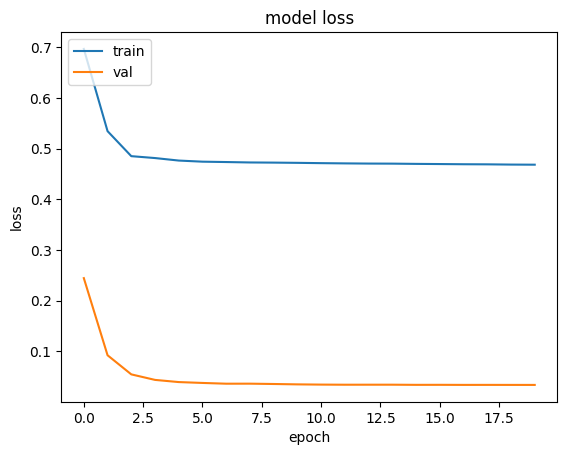

In [20]:
plot_loss(stacked_auto_encoder_1.history.history)

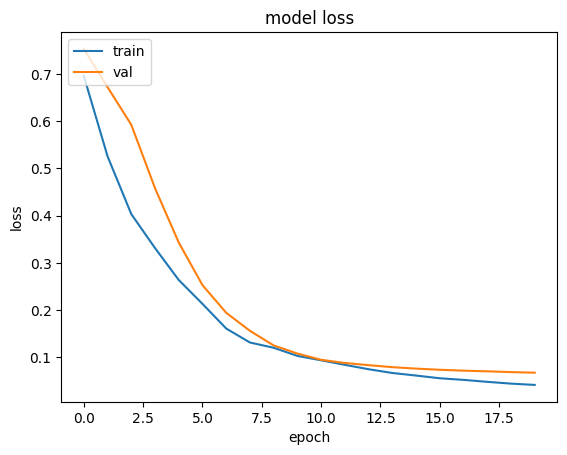

In [21]:
plot_loss(stacked_auto_encoder_2.history.history)

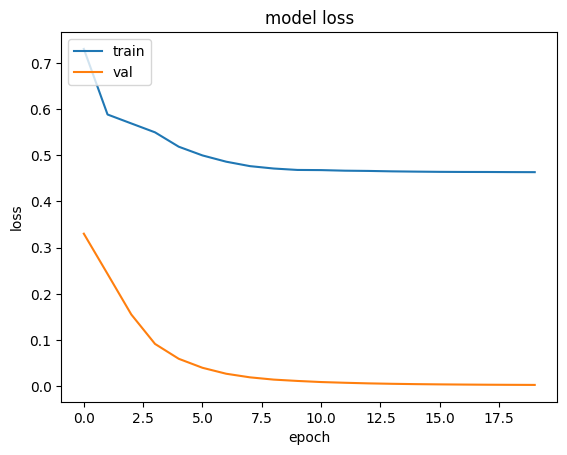

In [22]:
plot_loss(stacked_auto_encoder_3.history.history)

**Finetune the model by adding logistic regression layer**

In [23]:
# Create a 1 hot encoded Y_train
def create_one_hot(arr):
    out_arr = []
    for item in arr:
        max_arr = max(arr)
        one_hot_encoded = [0] * (max_arr+1)
        one_hot_encoded[item] = 1
        out_arr.append(one_hot_encoded)
    return np.array(out_arr)

Y_train_hot_encoded = create_one_hot(Y_train)
Y_val_hot_encoded = create_one_hot(Y_val)

In [24]:
fine_tuned_model_1, fine_tuned_encoder_1 = stacked_auto_encoder_1.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1) 

Epoch 1/30
1/3 [=========>....................] - ETA: 0s - loss: 1.0986
Epoch 1: val_loss improved from inf to 0.11904, saving model to weights.hdf5
3/3 [==============================] - 0s 108ms/step - loss: 1.1487 - val_loss: 0.1190
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 0.1190
Epoch 2: val_loss improved from 0.11904 to 0.00301, saving model to weights.hdf5
3/3 [==============================] - 0s 66ms/step - loss: 0.7721 - val_loss: 0.0030
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 0.0030
Epoch 3: val_loss improved from 0.00301 to 0.00010, saving model to weights.hdf5
3/3 [==============================] - 0s 66ms/step - loss: 0.7332 - val_loss: 1.0216e-04
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 1.0216e-04
Epoch 4: val_loss improved from 0.00010 to 0.00001, saving model to weights.hdf5
3/3 [==============================] - 0s 75ms/step - loss: 0.7318 - val_loss: 5.2452e-06
Epoch 5/30
1/3 [=========>.....

In [25]:
fine_tuned_model_2, fine_tuned_encoder_2 = stacked_auto_encoder_2.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1)

Epoch 1/30
1/3 [=========>....................] - ETA: 0s - loss: 0.5991
Epoch 1: val_loss improved from inf to 1.25651, saving model to weights.hdf5
3/3 [==============================] - 0s 114ms/step - loss: 2.2426 - val_loss: 1.2565
Epoch 2/30
1/3 [=========>....................] - ETA: 0s - loss: 1.2565
Epoch 2: val_loss improved from 1.25651 to 0.36031, saving model to weights.hdf5
3/3 [==============================] - 0s 75ms/step - loss: 1.0869 - val_loss: 0.3603
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 0.1567
Epoch 3: val_loss improved from 0.36031 to 0.10068, saving model to weights.hdf5
3/3 [==============================] - 0s 76ms/step - loss: 0.1561 - val_loss: 0.1007
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 0.1007
Epoch 4: val_loss improved from 0.10068 to 0.01045, saving model to weights.hdf5
3/3 [==============================] - 0s 75ms/step - loss: 0.2354 - val_loss: 0.0104
Epoch 5/30
1/3 [=========>.................

In [26]:
fine_tuned_model_3, fine_tuned_encoder_3 = stacked_auto_encoder_3.finetune(X_train_scaled, Y_train_hot_encoded, X_val_scaled, Y_val_hot_encoded, 30, 1) 

Epoch 1/30
1/3 [=========>....................] - ETA: 0s - loss: 0.8529
Epoch 1: val_loss improved from inf to 0.18619, saving model to weights.hdf5
3/3 [==============================] - 0s 127ms/step - loss: 1.5185 - val_loss: 0.1862
Epoch 2/30
3/3 [==============================] - ETA: 0s - loss: 0.8313
Epoch 2: val_loss improved from 0.18619 to 0.02143, saving model to weights.hdf5
3/3 [==============================] - 0s 81ms/step - loss: 0.8313 - val_loss: 0.0214
Epoch 3/30
1/3 [=========>....................] - ETA: 0s - loss: 0.0214
Epoch 3: val_loss improved from 0.02143 to 0.00484, saving model to weights.hdf5
3/3 [==============================] - 0s 78ms/step - loss: 0.5887 - val_loss: 0.0048
Epoch 4/30
1/3 [=========>....................] - ETA: 0s - loss: 1.0536
Epoch 4: val_loss improved from 0.00484 to 0.00176, saving model to weights.hdf5
3/3 [==============================] - 0s 94ms/step - loss: 0.5370 - val_loss: 0.0018
Epoch 5/30
1/3 [=========>.................

### Plot of Finetuning Training

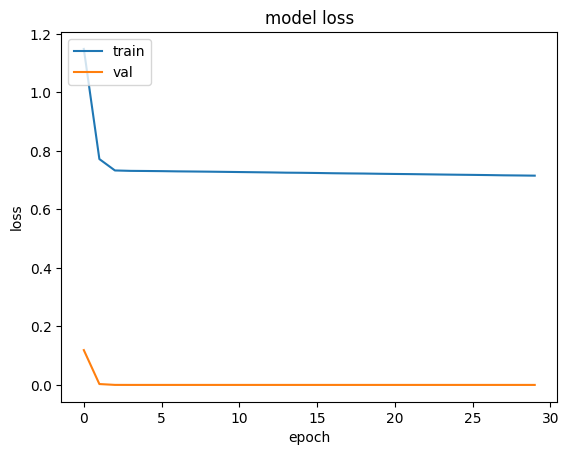

In [27]:
plot_loss(stacked_auto_encoder_1.history.history)

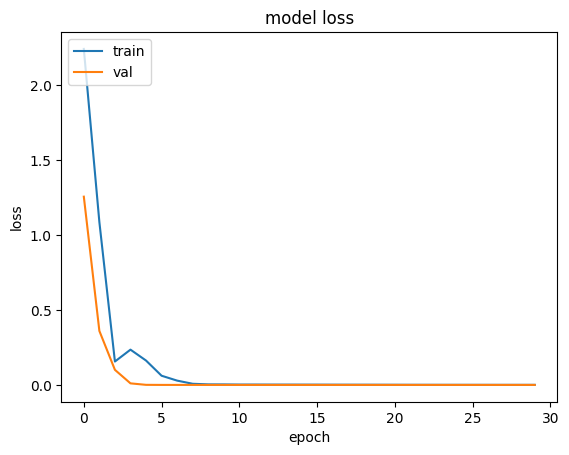

In [28]:
plot_loss(stacked_auto_encoder_2.history.history)

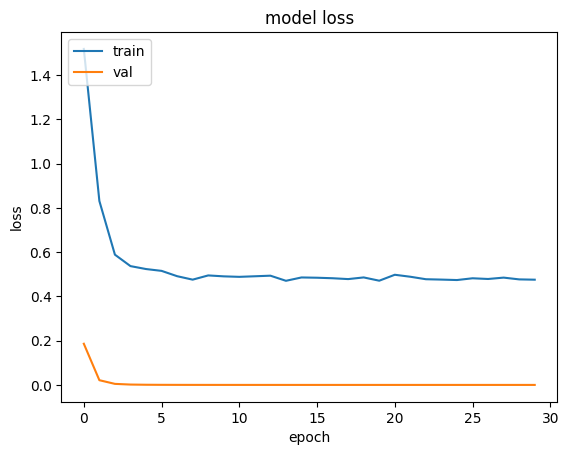

In [29]:
plot_loss(stacked_auto_encoder_3.history.history)

**Now feed the encoded representation into linear SVM**

In [30]:
fine_tuned_encoders = [fine_tuned_encoder_1, fine_tuned_encoder_2, fine_tuned_encoder_3]
for fine_tuned_encoder, model_name in zip(fine_tuned_encoders, model_names[1:]):
    print(model_name)
    X_train_encoded = fine_tuned_encoder.predict(X_train_scaled)

    # Fit to encoded data
    svm_autoencoder = SVC(kernel='linear', C=1)
    svm_autoencoder.fit(X_train_encoded, Y_train)

    # Encode the test data and use SVM to predict its labels
    X_test_encoded = fine_tuned_encoder.predict(X_test_scaled)
    predicted = svm_autoencoder.predict(X_test_encoded)

    # print(Y_test)
    # print("########################")
    # print(predicted)

    print("SVM Accuracy Score -> ", metrics.accuracy_score(predicted, Y_test)*100)
    predicted_arr.append(predicted)
    
    predicted_train = svm_autoencoder.predict(X_train_encoded)
    print("SVM Accuracy Score on training -> ", metrics.accuracy_score(predicted_train, Y_train)*100)

    X_val_encoded = fine_tuned_encoder.predict(X_val_scaled)
    predicted_val = svm_autoencoder.predict(X_val_encoded)
    print("SVM Accuracy Score on validation -> ", metrics.accuracy_score(predicted_val, Y_val)*100)

1-layer SDAE SVM
1/1 [==============================] - 0s 15ms/step
SVM Accuracy Score ->  0.0
SVM Accuracy Score on training ->  66.66666666666666
1/1 [==============================] - 0s 15ms/step
SVM Accuracy Score on validation ->  100.0
2-layers SDAE SVM
1/1 [==============================] - 0s 15ms/step
SVM Accuracy Score ->  100.0
SVM Accuracy Score on training ->  100.0
1/1 [==============================] - 0s 17ms/step
SVM Accuracy Score on validation ->  100.0
3-layers SDAE SVM
1/1 [==============================] - 0s 20ms/step
SVM Accuracy Score ->  0.0
SVM Accuracy Score on training ->  66.66666666666666
1/1 [==============================] - 0s 20ms/step
SVM Accuracy Score on validation ->  100.0


## 6. Testing metrics

In [31]:
def testing_metrics(y_true, y_pred_arr, model_names, export=True):
    stats = {}
    for y_pred, model_name in zip(y_pred_arr, model_names):
        scores = metrics.classification_report(y_true, y_pred, zero_division=1, output_dict=True)

        stats[model_name] = {
            'cohen_kappa': metrics.cohen_kappa_score(y_true, y_pred),
            'matthews_corrcoef': metrics.matthews_corrcoef(y_true, y_pred),
            'micro-accuracy': scores['accuracy']
        }

        for metr1 in ('macro avg', 'weighted avg'):
            for metr2 in ('precision', 'recall', 'f1-score'):
                stats[model_name][metr1 + ' ' + metr2] = scores[metr1][metr2]
    
    stats_df = pd.DataFrame.from_dict(stats).T
    if export:
        stats_df.to_csv('svm_stats.csv')
    
    return stats_df

In [32]:
testing_metrics(Y_test, predicted_arr, model_names)

/home/duke/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:663: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/home/duke/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:663: RuntimeWarning: invalid value encountered in double_scalars
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


,cohen_kappa,matthews_corrcoef,micro-accuracy,macro avg precision,macro avg recall,macro avg f1-score,weighted avg precision,weighted avg recall,weighted avg f1-score
Raw SVM,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1-layer SDAE SVM,0.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0
2-layers SDAE SVM,NaN,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3-layers SDAE SVM,0.0,0.0,0.0,0.5,0.5,0.0,1.0,0.0,0.0
